In [1]:
#For model data
import sys
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

#for saving output
import csv
import os
import pickle

#for calculating time difference
from datetime import datetime, timedelta

from scipy.interpolate import RegularGridInterpolator

#Tools for evaraging model data
sys.path.append(r'../tools')

In [2]:
dataset0 = xr.open_dataset("https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_eps/barents_eps_20230211T00Z.nc")
dataset1 = xr.open_dataset("https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_eps/barents_eps_20230211T06Z.nc")
dataset2 = xr.open_dataset("https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_eps/barents_eps_20230211T12Z.nc")
dataset3 = xr.open_dataset("https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_eps/barents_eps_20230211T18Z.nc")
dataset4 = xr.open_dataset("https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_eps/barents_eps_20230213T00Z.nc")
dataset5 = xr.open_dataset("https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_eps/barents_eps_20230213T12Z.nc")
dataset6 = xr.open_dataset("https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_eps/barents_eps_20230213T18Z.nc")
dataset7 = xr.open_dataset("https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_eps/barents_eps_20230214T00Z.nc")
dataset8 = xr.open_dataset("https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_eps/barents_eps_20230214T06Z.nc")

In [3]:
# Create a list of 4 datasets preceding to the forecast start 
datasets = [dataset0, dataset1, dataset2, dataset3]

In [4]:
# Print ensemles numbers for each dataset, stirat and end time
# All datasets (with 66 hours forecast) covers the whole forecasting period between SAR1 and SAR2
print("Ensembles")
for idx, ensemble in enumerate(datasets):
    print(f"dataset{idx}: {datasets[idx].ensemble_member.values}")
print("Start time")
for idx, ensemble in enumerate(datasets):
    print(f"dataset{idx}: {datasets[idx].time[0].values} - {datasets[idx].time[-1].values}, {len(datasets[idx].time)- 1} forecast")

Ensembles
dataset0: [0 1 2 3 4 5]
dataset1: [ 6  7  8  9 10 11]
dataset2: [12 13 14 15 16 17]
dataset3: [18 19 20 21 22 23]
Start time
dataset0: 2023-02-11T00:00:00.000000000 - 2023-02-13T18:00:00.000000000, 66 forecast
dataset1: 2023-02-11T06:00:00.000000000 - 2023-02-14T00:00:00.000000000, 66 forecast
dataset2: 2023-02-11T12:00:00.000000000 - 2023-02-14T06:00:00.000000000, 66 forecast
dataset3: 2023-02-11T18:00:00.000000000 - 2023-02-14T12:00:00.000000000, 66 forecast


In [5]:
# Generate fixed variables

X = dataset0['X']
Y = dataset0['Y']
lon = dataset0['lon']
lat = dataset0['lat']
model_proj4 = dataset0.projection_lambert.proj4

In [6]:
# Generates lists of variables which changes from dataset to dataset
ensemble_members_list = []
ice_u_list = []
ice_v_list = []
siconc_list = []

for idx, ds in enumerate(datasets):
    ensemble_member = ds['ensemble_member']
    ensemble_members_list.append(ensemble_member)
    
    ice_u = ds['ice_u']
    ice_u_list.append(ice_u)
    
    ice_v = ds['ice_v']
    ice_v_list.append(ice_v)
    
    siconc = ds['ice_concentration']
    siconc_list.append(siconc)

In [123]:
from model_data_prep import round_start_time, round_end_time, time_difference

# SAR images timestamps
t_sar1 = '2022-11-19T07:22:08'
t_sar2 = '2022-11-20T08:02:59'

# Rounding the SAR timestamps to align with the nearest whole hour of model timestamps
t_start = round_start_time(t_sar1)
t_end = round_end_time(t_sar2)

print(f'SAR1 time is {t_sar1}, Model start time for the time period is {t_start}')
print(f'SAR2 time is {t_sar2}, Model end time for the time period is {t_end}')


# Extracting the model time variavle data corresponding to the time period between the rounded start and end times
time_period = dataset0.time.sel(time=slice(t_start,t_end))

print(f'The duration of the time period is {len(time_period)-1} whole hours')

SAR1 time is 2022-11-19T07:22:08, Model start time for the time period is 2022-11-19T07:00:00
SAR2 time is 2022-11-20T08:02:59, Model end time for the time period is 2022-11-20T09:00:00
The duration of the time period is 26 whole hours


In [124]:
time_diff_start, time_diff_end, total_time_diff = time_difference(t_sar1, t_sar2, time_period)

Time difference between SAR1 and the start of the model time period is 1328 seconds (22.133 minutes).
Time difference between SAR2 and the end of the model time period is 3421 seconds (57.017 minutes).
Total time difference between SAR1 and SAR2 images is 88851 seconds (1.028 days).


In [125]:
#Import variables for extracting subsets from SAR1-SAR2_drift.ipynb
%store -r r
%store -r c
%store -r X_subset
%store -r Y_subset
%store -r lon_subset
%store -r lat_subset

In [126]:
ice_u.shape

(67, 6, 949, 739)

In [127]:
# Extraxt within subset
ice_u_subset_list = []
ice_v_subset_list = []
siconc_subset_list = []

for ice_u in ice_u_list:
    subset = ice_u.sel(time=slice(t_start, t_end))[:, :, min(r):max(r)+1, min(c):max(c)+1].fillna(np.nan)
    ice_u_subset_list.append(subset)
    
for ice_v in ice_v_list:
    subset = ice_v.sel(time=slice(t_start, t_end))[:, :, min(r):max(r)+1, min(c):max(c)+1].fillna(np.nan)
    ice_v_subset_list.append(subset)

for siconc in siconc_list:
    subset = siconc.sel(time=slice(t_start, t_end))[:, :, min(r):max(r)+1, min(c):max(c)+1].fillna(np.nan)
    siconc_subset_list.append(subset)


In [128]:
# First, concatenate all DataArrays along the ensemble_member dimension
combined_ice_u = xr.concat(ice_u_subset_list, dim='ensemble_member')
combined_ice_v = xr.concat(ice_v_subset_list, dim='ensemble_member')
combined_siconc = xr.concat(siconc_subset_list, dim='ensemble_member')

In [129]:
# Now, compute the mean over the ensemble_member dimension
mean_ice_u = combined_ice_u.mean(dim='ensemble_member')
mean_ice_v = combined_ice_v.mean(dim='ensemble_member')
mean_siconc = combined_siconc.mean(dim='ensemble_member')

In [130]:
mean_timeperiod_siconc = mean_siconc.mean(dim='time')

In [131]:
# Export mean_siconc for comparison of model and reference drift (for filtering)
# See notebook drift_comparison.ipynb)
%store mean_siconc
%store mean_timeperiod_siconc

Stored 'mean_siconc' (DataArray)
Stored 'mean_timeperiod_siconc' (DataArray)


In [41]:
from model_data_prep import cumulative_ice_displacement

In [45]:
xx, yy, int_dx, int_dy = cumulative_ice_displacement(X_subset,Y_subset, mean_ice_u, mean_ice_v,time_period, time_diff_start,time_diff_end)

1 hour done
2 hour done
3 hour done
4 hour done
5 hour done
6 hour done
7 hour done
8 hour done
9 hour done
10 hour done
11 hour done
12 hour done
13 hour done
14 hour done
15 hour done
16 hour done
17 hour done
18 hour done
19 hour done
20 hour done
21 hour done
22 hour done
23 hour done
24 hour done
25 hour done
26 hour done


In [47]:
output_dir_subset_comp =  r'/home/jovyan/data/model_data_process_output/for_comparison_24ens_mean'

In [52]:
lon1 = lon_subset.data.flatten()
lat1 = lat_subset.data.flatten()

points=zip(lon1, lat1, int_dx[-1], int_dy[-1])
header=['lon1','lat1', 'du','dv']

time_index_start = pd.to_datetime(time_period[0].values)
time_index_end = pd.to_datetime(time_period[-1].values)
filename_t_start = time_index_start.strftime('%Y%m%dT%H')
filename_t_end = time_index_end.strftime('%Y%m%dT%H')
        
file_name = f'24ens_cum_displacement_{filename_t_start}-{filename_t_end}.csv'
file_path = os.path.join(output_dir_subset_comp, file_name)

with open(file_path, 'w', newline='') as csv_file:
            out = csv.writer(csv_file, delimiter=',')
            out.writerow(header)
            out.writerows(points)

##### Calculation of variation

Variance should be calculated for the model data used for forecast and comparison. In this case standart deviation is applied for mean velocities over all 24 ensembles ober 27 timestamps. As we use instantanious speed values in Barents2.5 model it was important to check if there is a big variance in data.
If it is, it means that using instantanious dtaa can effect stringly calculation of the mean hourly displacement for the forecasting purposes. 
What we see is that for the areas with vortexes and marginal ice zone standart deviation is quite big relatively to mean values. It means that using instantanious values might be not the best way (?). 
But also absolute values effect a lot, the biggest deviation (and coefficient of variation) take place in areas where velocities are very low making even not big absolute changes effecting standart deviation a lot. 
To overcome this problem, the standart deviation was normalised also by total mean velocity for teh whole subset (does it make sense?)


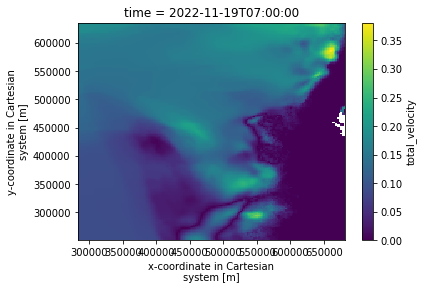

In [385]:
total_velocity = np.sqrt(mean_ice_u**2 + mean_ice_u**2)
total_velocity.name = "total_velocity"
total_velocity[0].plot()

/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


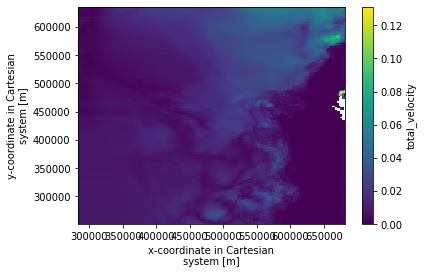

In [387]:
velocity_variation = total_velocity.std(dim='time')
velocity_variation.plot()

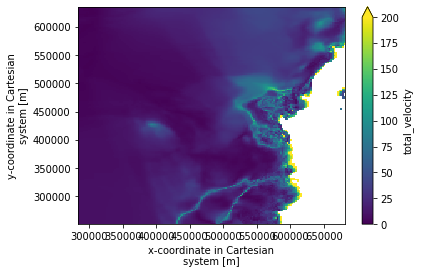

In [389]:
mean_velocity = total_velocity.mean(dim='time')
CV = (velocity_variation / mean_velocity) * 100
CV.plot(vmin=0, vmax=200)

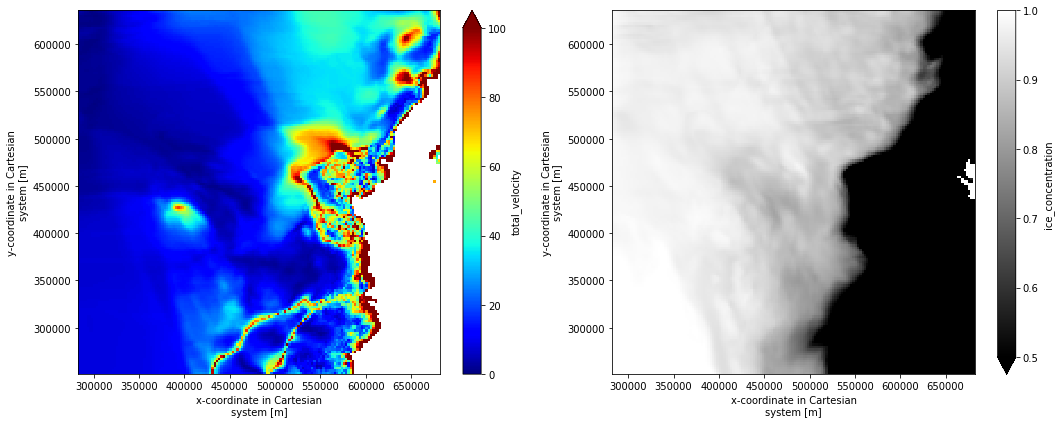

In [167]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

CV.plot(ax=ax1, cmap = 'jet',  vmin=0, vmax=100)
mean_timeperiod_siconc.plot(ax=ax2, cmap = 'gray', vmin=0.5, vmax=1)
plt.tight_layout()
plt.show()

what if normalise towards the whole subset mean..

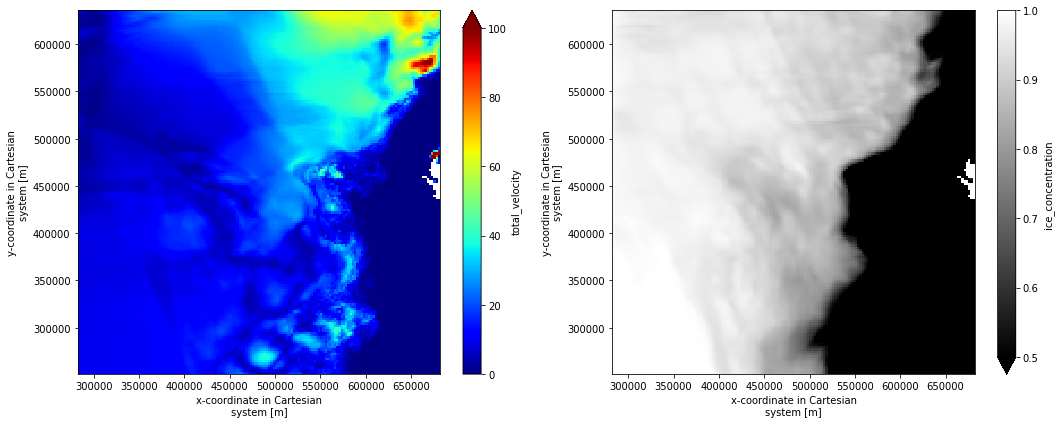

In [168]:
total_meam = np.mean(mean_velocity)

CV2 = (velocity_variation / total_meam) * 100

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

CV2.plot(ax=ax1, cmap = 'jet', vmin=0, vmax=100)
mean_timeperiod_siconc.plot(ax=ax2, cmap = 'gray', vmin=0.5, vmax=1)
plt.tight_layout()
plt.show()

#### Variant with rolling evarage of 24 ensembles for the whole forecasting period with 6 hour ensembles update.
Takes 4 preciding datasets for calculating mean 24 ensembles variables for the next 6 (or what is left before new update at 00,06,12,18) hours.
At time of new forecast drops the most outdated 6 ensembles and add the most recent 6.


Description of teh model:


Sea ice drift forecasts were generated using a model that releases data in discrete files at four specific times daily: 00:00, 06:00, 12:00, and 18:00. Each of these files provides an hourly forecast of instantaneous sea ice drift measurements projected for the subsequent 66 hours. Crucially, every file contains data from six distinct ensemble predictions, summing to a total of 24 unique ensembles over the course of a day. The ensembles are systematically numbered from 0 to 23, with the 00:00 file encompassing ensembles 0-5, the 06:00 file including ensembles 6-11, the 12:00 file comprising ensembles 12-17, and the 18:00 file containing ensembles 18-23. At the model's finest resolution of 2.5 km, we observed that the sea ice drift is profoundly influenced by ocean surface features, which emerge as vortices in the drift data. It's worth noting that such vortices at this granularity are not commonly evident in real-world observations. Given the variability of these vortices across different ensembles, we employed an averaging technique across ensembles to decrease their influence and enhance the accuracy of our forecasts.



* From the article (also it makes sense to take some general info from Victor's article)
The sea ice model used in Barents-2.5 is the Los Alamos sea ice model (CICE), version 5.1 (Hunke et al., 2017). CICE describes both dynamic and thermodynamic processes, using a elastic-viscous-plastic (EVP) rheology (Hunke and Dukowicz, 1997, Röhrs et al, 2023). The ice velocity u is calculated from the sea ice momentum equation that account for air and water drag, Coriolis force, sea surface tilt, and the divergence of internal ice stress.

In [3]:
# Extract grid variables

X = dataset0['X']
Y = dataset0['Y']
lon = dataset0['lon']
lat = dataset0['lat']
model_proj4 = dataset0.projection_lambert.proj4


In [4]:
%store X
%store Y
#%store lon
#%store lat
%store model_proj4

Stored 'X' (DataArray)
Stored 'Y' (DataArray)
Stored 'model_proj4' (str)


In [5]:
datasets = [dataset0, dataset1, dataset2, dataset3, dataset4, dataset5, dataset6, dataset7, dataset8]

In [6]:
print("Ensembles")
for idx, ensemble in enumerate(datasets):
    print(f"dataset{idx}: {datasets[idx].ensemble_member.values}")
print("Start time")
for idx, ensemble in enumerate(datasets):
    print(f"dataset{idx}: {datasets[idx].time[0].values} - {datasets[idx].time[-1].values}, {len(datasets[idx].time)- 1} forecast")



Ensembles
dataset0: [0 1 2 3 4 5]
dataset1: [ 6  7  8  9 10 11]
dataset2: [12 13 14 15 16 17]
dataset3: [18 19 20 21 22 23]
dataset4: [0 1 2 3 4 5]
dataset5: [12 13 14 15 16 17]
dataset6: [18 19 20 21 22 23]
dataset7: [0 1 2 3 4 5]
dataset8: [ 6  7  8  9 10 11]
Start time
dataset0: 2023-02-11T00:00:00.000000000 - 2023-02-13T18:00:00.000000000, 66 forecast
dataset1: 2023-02-11T06:00:00.000000000 - 2023-02-14T00:00:00.000000000, 66 forecast
dataset2: 2023-02-11T12:00:00.000000000 - 2023-02-14T06:00:00.000000000, 66 forecast
dataset3: 2023-02-11T18:00:00.000000000 - 2023-02-14T12:00:00.000000000, 66 forecast
dataset4: 2023-02-13T00:00:00.000000000 - 2023-02-15T18:00:00.000000000, 66 forecast
dataset5: 2023-02-13T12:00:00.000000000 - 2023-02-16T06:00:00.000000000, 66 forecast
dataset6: 2023-02-13T18:00:00.000000000 - 2023-02-16T12:00:00.000000000, 66 forecast
dataset7: 2023-02-14T00:00:00.000000000 - 2023-02-16T18:00:00.000000000, 66 forecast
dataset8: 2023-02-14T06:00:00.000000000 - 2023-

In [7]:
from model_data_prep import round_start_time, round_end_time, time_difference

# SAR images timestamps
t_sar1 = '2023-02-12T08:01:51'
t_sar2 = '2023-02-14T07:45:31'

# Rounding the SAR timestamps to align with the nearest whole hour of model timestamps
t_start = round_start_time(t_sar1)
t_end = round_end_time(t_sar2)

print(f'SAR1 time is {t_sar1}, Model start time for the time period is {t_start}')
print(f'SAR2 time is {t_sar2}, Model end time for the time period is {t_end}')


# Extracting the model time variavle data corresponding to the time period between the rounded start and end times
time_period_barents = dataset3.time.sel(time=slice(t_start,t_end))

print(f'The duration of the time period is {len(time_period_barents)-1} whole hours')

SAR1 time is 2023-02-12T08:01:51, Model start time for the time period is 2023-02-12T08:00:00
SAR2 time is 2023-02-14T07:45:31, Model end time for the time period is 2023-02-14T08:00:00
The duration of the time period is 48 whole hours


In [8]:
time_period_barents

<xarray.DataArray 'time' (time: 49)>
array(['2023-02-12T08:00:00.000000000', '2023-02-12T09:00:00.000000000',
       '2023-02-12T10:00:00.000000000', '2023-02-12T11:00:00.000000000',
       '2023-02-12T12:00:00.000000000', '2023-02-12T13:00:00.000000000',
       '2023-02-12T14:00:00.000000000', '2023-02-12T15:00:00.000000000',
       '2023-02-12T16:00:00.000000000', '2023-02-12T17:00:00.000000000',
       '2023-02-12T18:00:00.000000000', '2023-02-12T19:00:00.000000000',
       '2023-02-12T20:00:00.000000000', '2023-02-12T21:00:00.000000000',
       '2023-02-12T22:00:00.000000000', '2023-02-12T23:00:00.000000000',
       '2023-02-13T00:00:00.000000000', '2023-02-13T01:00:00.000000000',
       '2023-02-13T02:00:00.000000000', '2023-02-13T03:00:00.000000000',
       '2023-02-13T04:00:00.000000000', '2023-02-13T05:00:00.000000000',
       '2023-02-13T06:00:00.000000000', '2023-02-13T07:00:00.000000000',
       '2023-02-13T08:00:00.000000000', '2023-02-13T09:00:00.000000000',
       '2023-02-13T10:00:00.000000000', '2023-02-13T11:00:00.000000000',
       '2023-02-13T12:00:00.000000000', '2023-02-13T13:00:00.000000000',
       '2023-02-13T14:00:00.000000000', '2023-02-13T15:00:00.000000000',
       '2023-02-13T16:00:00.000000000', '2023-02-13T17:00:00.000000000',
       '2023-02-13T18:00:00.000000000', '2023-02-13T19:00:00.000000000',
       '2023-02-13T20:00:00.000000000', '2023-02-13T21:00:00.000000000',
       '2023-02-13T22:00:00.000000000', '2023-02-13T23:00:00.000000000',
       '2023-02-14T00:00:00.000000000', '2023-02-14T01:00:00.000000000',
       '2023-02-14T02:00:00.000000000', '2023-02-14T03:00:00.000000000',
       '2023-02-14T04:00:00.000000000', '2023-02-14T05:00:00.000000000',
       '2023-02-14T06:00:00.000000000', '2023-02-14T07:00:00.000000000',
       '2023-02-14T08:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2023-02-12T08:00:00 ... 2023-02-14T08:00:00
Attributes:
    long_name:      time since initialization
    field:          time, scalar, series
    axis:           T
    standard_name:  time
    _ChunkSizes:    1

In [16]:
# Store variables
time_diff_start, time_diff_end, total_time_diff = time_difference(t_sar1, t_sar2, time_period_barents)

%store time_diff_start
%store time_diff_end
%store total_time_diff
%store time_period_barents

Time difference between SAR1 and the start of the model time period is 111 seconds (1.85 minutes).
Time difference between SAR2 and the end of the model time period is 869 seconds (14.483 minutes).
Total time difference between SAR1 and SAR2 images is 171820 seconds (1.989 days).
Stored 'time_diff_start' (int64)
Stored 'time_diff_end' (int64)
Stored 'total_time_diff' (int64)
Stored 'time_period_barents' (DataArray)


Methodology: Rolling Averaging of Ensemble Ice Drift Velocities

The goal of this methodology is to compute the average ice drift velocities, specifically ice_u and ice_v, over a designated time range using a sliding window of ensemble forecasts. This approach seeks to always use the latest available ensemble forecasts to provide an updated and more accurate representation of ice drift velocities.

Defining the Forecast Time Range:
The start and end times of the forecast period are specified. The period is then divided into hourly intervals using the pd.date_range() function, producing a sequence of timestamps.

Selection of Relevant Datasets:
For each hourly timestamp:

All datasets that have forecast data encompassing the current timestamp are identified.
These datasets are sorted based on their starting forecast time.
The four most recent datasets are selected to ensure the usage of the latest ensemble forecasts.
Data Extraction and Concatenation:
For each of the selected datasets, the ice_u and ice_v data corresponding to the current timestamp are extracted. Additionally, a spatial subset of the data is chosen based on specified row (r) and column (c) indices. To handle missing data, any NaN values are retained by using the fillna(np.nan) function. The extracted ensemble data from all four datasets are concatenated along a new dimension named ensemble_member, resulting in a combined dataset with data from 24 ensemble members.

Averaging Over Ensembles:
The concatenated ensemble data are then averaged over the ensemble_member dimension, yielding a single averaged value for ice_u and ice_v for each hourly timestamp.

Creation of Time Series DataArrays:
The hourly averaged ice_u and ice_v values are concatenated along the time dimension, producing two continuous time series DataArray objects that represent the average ice drift velocities over the entire forecast period.

The rolling_avg_24_ensembles function implements the aforementioned methodology, taking as input a list of ensemble datasets and the desired start and end times of the forecast period. It returns two DataArray objects containing the averaged ice drift velocities (avg_ice_u_da and avg_ice_v_da) for the entire period. This approach ensures a continuous and updated representation of the average ice drift velocities by always considering the latest ensemble forecasts.

Short version:
To provide a continuous and updated representation of ice drift velocities, we employed a rolling averaging approach. For each hour within a designated forecast period, we sourced data from the four most recent ensemble forecast datasets available at that time. By prioritizing the latest ensemble forecasts, we ensured the inclusion of the most up-to-date predictions in our analysis. For each hourly timestep, the ice drift velocities were extracted from these datasets, spatially subsetted, and then averaged across all 24 ensemble members. This process generated a time series of average ice drift velocities spanning the entire forecast period.

##### Calculating rolling average for full and subset gtids

In [10]:
from model_data_prep import rolling_avg_24_ensembles

In [11]:
# For the whole extent
avg_ice_u, avg_ice_v = rolling_avg_24_ensembles(datasets, t_start, t_end, subset = False)

##### Calculate mean hourly (NOT cumulutiv) drift

In [13]:
from model_data_prep import non_cumulative_ice_displacement

In [14]:
xx, yy, hourly_mean_disp_uhourly_mean_ice_v, hourly_mean_disp_u =  non_cumulative_ice_displacement(X, Y, avg_ice_u, avg_ice_v, time_period_barents, time_diff_start, time_diff_end)

1 hour done
2 hour done
3 hour done
4 hour done
5 hour done
6 hour done
7 hour done
8 hour done
9 hour done
10 hour done
11 hour done
12 hour done
13 hour done
14 hour done
15 hour done
16 hour done
17 hour done
18 hour done
19 hour done
20 hour done
21 hour done
22 hour done
23 hour done
24 hour done
25 hour done
26 hour done
27 hour done
28 hour done
29 hour done
30 hour done
31 hour done
32 hour done
33 hour done
34 hour done
35 hour done
36 hour done
37 hour done
38 hour done
39 hour done
40 hour done
41 hour done
42 hour done
43 hour done
44 hour done
45 hour done
46 hour done
47 hour done
48 hour done


##### Saving speed as pickle files

In [15]:
pickle_path_u = "/home/jovyan/experiment_data/2022-2023_48h_experiment/drift_output/14_16_feb/barents_24ens_14_16feb_hourly_ice_u.pkl"
pickle_path_v = "/home/jovyan/experiment_data/2022-2023_48h_experiment/drift_output/14_16_feb/barents_24ens_14_16feb_hourly_ice_v.pkl"
# Save the list
with open(pickle_path_u, "wb") as f:
    pickle.dump(hourly_mean_disp_u, f)
    
with open(pickle_path_v, "wb") as f:
    pickle.dump(hourly_mean_disp_v, f)

##### Calculating cummulative (integrated) drift for the full extent

In [94]:
from model_data_prep import cumulative_ice_displacement

In [95]:
# Calculate cumulative drift for the whole grid 
xx_b, yy_b, cum_dx_b, cum_dy_b = cumulative_ice_displacement(X, Y, avg_ice_u, avg_ice_v, time_period_barents, time_diff_start, time_diff_end)

1 hour done
2 hour done
3 hour done
4 hour done
5 hour done
6 hour done
7 hour done
8 hour done
9 hour done
10 hour done
11 hour done
12 hour done
13 hour done
14 hour done
15 hour done
16 hour done
17 hour done
18 hour done
19 hour done
20 hour done
21 hour done
22 hour done
23 hour done
24 hour done
25 hour done
26 hour done
27 hour done
28 hour done
29 hour done
30 hour done
31 hour done
32 hour done
33 hour done
34 hour done
35 hour done
36 hour done
37 hour done
38 hour done
39 hour done
40 hour done
41 hour done
42 hour done
43 hour done
44 hour done
45 hour done
46 hour done
47 hour done
48 hour done


##### Saving cum displacements as pickle files

In [98]:
pickle_path_u = "/home/jovyan/experiment_data/2022-2023_48h_experiment/drift_output/14_16_feb/barents_24ens_14_16feb_cum_ice_u.pkl"
pickle_path_v = "/home/jovyan/experiment_data/2022-2023_48h_experiment/drift_output/14_16_feb/barents_24ens_14_16feb_cum_ice_v.pkl"
# Save the list
with open(pickle_path_u, "wb") as f:
    pickle.dump(cum_dx_b, f)
    
with open(pickle_path_v, "wb") as f:
    pickle.dump(cum_dy_b, f)

##### Calculating cummulative (integrated) drift for the subset extent

In [ ]:
#Import variables for extracting subsets from SAR1-SAR2_drift.ipynb
%store -r r
%store -r c
%store -r X_subset
%store -r Y_subset
%store -r lon_subset
%store -r lat_subset

In [9]:
# For the subset if provided
avg_ice_u_subset, avg_ice_v_subset = rolling_avg_24_ensembles(datasets, t_start, t_end, subset = True)

In [52]:
# Calculate cumulative drift for subset grid 
xx_b_subset, yy_b_subset, cum_dx_b_subset, cum_dy_b_subset = cumulative_ice_displacement(X_subset,Y_subset, avg_ice_u_subset, avg_ice_v_subset, time_period_barents, time_diff_start,time_diff_end)

1 hour done
2 hour done
3 hour done
4 hour done
5 hour done
6 hour done
7 hour done
8 hour done
9 hour done
10 hour done
11 hour done
12 hour done
13 hour done
14 hour done
15 hour done
16 hour done
17 hour done
18 hour done
19 hour done
20 hour done
21 hour done
22 hour done
23 hour done
24 hour done
25 hour done
26 hour done


In [17]:
#Store variables
%store xx_b
%store yy_b
%store cum_dx_b
%store cum_dy_b 

'''
%store xx_b_subset
%store yy_b_subset
%store cum_dx_b_subset
%store cum_dy_b_subset 
'''

Stored 'xx_b' (list)
Stored 'yy_b' (list)
Stored 'cum_dx_b' (list)
Stored 'cum_dy_b' (list)


'\n%store xx_b_subset\n%store yy_b_subset\n%store cum_dx_b_subset\n%store cum_dy_b_subset \n'

##### Calculating average concentration for t[0]

In [65]:
dataset0.ensemble_member.values

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [71]:
def avg_concentration(datasets, time_period):

    available_datasets = [ds for ds in datasets if (ds.time[0].values <= time_period[0])]
    print(f'{len(available_datasets)} avalible datasets')
    conc_t_start_ens = xr.concat([ds.sel(time=time_period[0]).ice_concentration.fillna(np.nan) for ds in available_datasets], dim='ensemble_member')
    print(f'ensembles for averaging are {conc_t_start_ens.ensemble_member.values}')
    avg_conc_t_start = conc_t_start_ens.mean(dim='ensemble_member')
    
    return avg_conc_t_start

In [72]:
avg_conc_t_start = avg_concentration(datasets, time_period_barents)

4 avalible datasets
ensembles for averaging are [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [ ]:
feb1214_conc = avg_conc_t_start
%store feb1214_conc

Stored 'feb1214_conc' (DataArray)


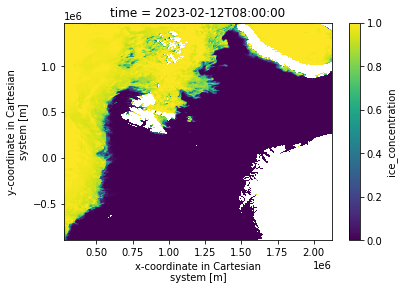

In [73]:
avg_conc_t_start.plot()


##### Export cumulative drift to csv  (For chalmers)
(alternative way is just to pass it as stored variables)

In [22]:
# full grid
output_dir_subset_comp =  r'/home/jovyan/experiment_data/2022-2023_48h_experiment/drift_output/14_16_feb'

lon1 = lon.data.flatten()
lat1 = lat.data.flatten()

points=zip(lon1, lat1, cum_dx_b[-1], cum_dy_b[-1])
header=['lon1','lat1', 'du','dv']

file_name = f'barents_24ens_cum_disp_14-16feb.csv'
file_path = os.path.join(output_dir_subset_comp, file_name)

with open(file_path, 'w', newline='') as csv_file:
            out = csv.writer(csv_file, delimiter=',')
            out.writerow(header)
            out.writerows(points)

In [39]:
# Subset grid
output_dir_subset_comp =  r'/home/jovyan/data/model_data_process_output/for_comparison/subset_comparison_with_sar'

lon1 = lon_subset.data.flatten()
lat1 = lat_subset.data.flatten()

points=zip(lon1, lat1, cum_dx_b_subset[-1], cum_dy_b_subset[-1])
header=['lon1','lat1', 'du','dv']

#file_name = f'24ens_roll_cum_displacement_{filename_t_start}-{filename_t_end}.csv'
file_name = f'barents_subset_24ens_cum_displacement.csv'
file_path = os.path.join(output_dir_subset_comp, file_name)

with open(file_path, 'w', newline='') as csv_file:
            out = csv.writer(csv_file, delimiter=',')
            out.writerow(header)
            out.writerows(points)

In [42]:
# Export for Chalmers forecasting (with buffer)

'''
need to add
'''

'\nneed to add\n'

##### Calculation of variations for estimation of realibility of instantanious values 

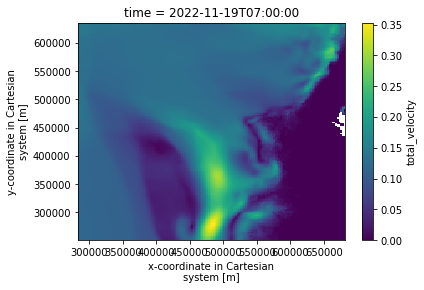

In [48]:
total_velocity_roll = np.sqrt(avg_ice_u_subset**2 + avg_ice_v_subset**2)
total_velocity_roll.name = "total_velocity"
total_velocity_roll[0].plot()

/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


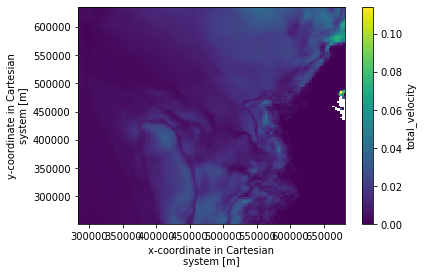

In [49]:
velocity_variation_roll = total_velocity_roll.std(dim='time')
velocity_variation_roll.plot()

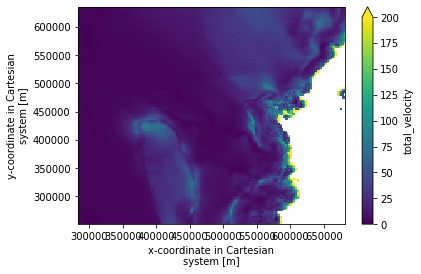

In [50]:
mean_velocity_roll = total_velocity_roll.mean(dim='time')
CV_roll = (velocity_variation_roll / mean_velocity_roll) * 100
CV_roll.plot(vmin=0, vmax=200)

Interesting the way rolling averaging provide less variation for gradient ice drift areas and more variation within vortecies..that makes sence that vortecies change a lot from ensemble to ensemble and every 6 hour. It probably means that they not that connected for one ensemble after 24 hours.  